### Tool 설치

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [2]:
!git config --global user.email "duwltn1301@naver.com"
!git config --global user.name "YeoJiSu"

### Training a new tokenizer from an old one

#### Assembling a corpus

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

# This can take a few minutes to load, so grab a coffee or tea while you wait!
raw_datasets = load_dataset("code_search_net", "python")

In [ ]:
raw_datasets["train"]

In [ ]:
print(raw_datasets["train"][123456]["whole_func_string"])

* 아래와 같이 처리하면 메모리에 모두 로드하기 때문에 효율적이지 X.
* Datasets 라이브러리를 사용하여 디스크에 저장된 데이터를 메모리에 로드하지 않고, 효율적으로 처리 가능.

In [ ]:
# Don't uncomment the following line unless your dataset is small!
# training_corpus = [raw_datasets["train"][i: i + 1000]["whole_func_string"] for i in range(0, len(raw_datasets["train"]), 1000)]

* 파이썬의 generator (괄호) 사용하면, 데이터를 한번에 로드하지 않고, 필요한 시점에 하나씩 처리 가능함.

In [ ]:
training_corpus = (
    raw_datasets["train"][i : i + 1000]["whole_func_string"]
    for i in range(0, len(raw_datasets["train"]), 1000)
)

* 하지만, 한번만 부를 수 있다는 단점이 있음.

In [ ]:
gen = (i for i in range(10))
print(list(gen))
print(list(gen))

* 그래서, 대신 함수로 정의한다.

In [ ]:
def get_training_corpus():
    return (
        raw_datasets["train"][i : i + 1000]["whole_func_string"]
        for i in range(0, len(raw_datasets["train"]), 1000)
    )


training_corpus = get_training_corpus()

* for문 내에 yield를 사용할 수 있다.
* yield는 함수를 일시 중지하고 값을 반환하는데 사용
* 함수가 다시 호출되면 일시 중지된 곳에서 실행을 계속하며, 지난 호출에서의 상태를 기억
* 함수가 호출될 때마다 한 번에 하나의 whole_func_string 값을 반환하므로 대량의 데이터를 메모리에 로드하지 않고도 효율적으로 처리 가능.

In [ ]:
def get_training_corpus():
    dataset = raw_datasets["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["whole_func_string"]

#### Training a new tokenizer

모델과 쌍을 이루고 싶은 토크나이저 로드

* 새로운 토크나이저를 훈련시키더라도 처음부터 완전히 시작하지 않도록 이렇게 하는 것이 좋다.
* 우리의 토크나이저는 GPT-2에서 어휘가 변경될 것이다.

In [ ]:
from transformers import AutoTokenizer # 빠른 토크나이저

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

* 토크나이저 처리 결과를 보면, 효율적이진 않다.

In [ ]:
example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

* 새로운 토크나이저를 훈련시켜서 이러한 문제가 해결되는지 살펴보겠습니다.

In [ ]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

* "빠른" 토크나이저는 Rust로 작성된 🤗 Tokenizers 라이브러리를 기반으로 함!
* 새로운 토크나이저의 훈련을 병렬화하거나, 입력 배치의 토큰화를 수행

In [ ]:
tokens = tokenizer.tokenize(example)
tokens

In [ ]:
print(len(tokens))
print(len(old_tokenizer.tokenize(example))) # 동일한 예에서 일반 영어 토크나이저를 사용하면 더 긴 문장이 제공된다.

* 다른 예

In [ ]:
example = """class LinearLayer():
    def __init__(self, input_size, output_size):
        self.weight = torch.randn(input_size, output_size)
        self.bias = torch.zeros(output_size)

    def __call__(self, x):
        return x @ self.weights + self.bias
    """
tokenizer.tokenize(example)

#### 토크나이저 저장

In [ ]:
tokenizer.save_pretrained("code-search-net-tokenizer")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
tokenizer.push_to_hub("code-search-net-tokenizer")

In [ ]:
# Replace "huggingface-course" below with your actual namespace to use your own tokenizer
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

### Fast tokenizers' special powers

#### Batch encoding

* 토크나이저의 출력은 Batch Encoding 객체이다
* offset mapping: 항상 최종 토큰이 어떤 원본 텍스트의 범위에서 나왔는지를 추적하는 것

아래의 출력 결과는 BatchEncdoing 객체이다.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

토크나이저가 빠른지 느린지 확인한다.

In [ ]:
tokenizer.is_fast

인코딩 된 것도 빠른지 느린지 확인한다.

In [ ]:
encoding.is_fast

1) Input ID (encoding)를 토큰으로 다시 변환하지 않고도 토큰에 엑세스 할 수 있다.

In [ ]:
encoding.tokens()
# ['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in', 'Brooklyn', '.', '[SEP]']

word_ids를 사용하여 각 토큰이 유래된 단어의 색인을 알 수 있다.

* 토크나이저의 특수 토큰 [CLS]와 [SEP]이 None으로 매핑

* sentence_ids(): 토큰을 해당 토큰이 속한 문장으로 매핑하는 메서드입니다.

* word_to_chars(), token_to_chars(), char_to_word(), char_to_token(): 어떤 단어 또는 토큰을 원본 텍스트의 문자에 매핑하거나 그 반대로 매핑할 수 있는 메서드들입니다.
* 예를 들어, word_ids() 메서드는 ##yl이 인덱스 3의 단어의 일부임을 알려줍니다.

In [ ]:
encoding.word_ids()
# [None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

In [ ]:
start, end = encoding.word_to_chars(3)
example[start:end]
# 답: Sylvain

#### Inside the token-classification pipeline

[Getting the base results with the pipeline]

* entity 출력

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

* entity_group 출력
* aggregation_stratecy -> 각 그룹화된 엔터티에 대해 계산된 점수를 변경할 수 있다
* aggregation_stratecy 종류

    * simple: 각 토큰의 점수의 평균
    * first: 해당 엔터티의 첫 번째 토큰의 점수
    * max:  해당 엔터티의 토큰 중 가장 높은 점수
    * average: 해당 엔터티를 구성하는 단어의 점수의 평균

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

[From inputs to predictions]

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

* 모델에 넣고, output인 logits을 얻을 수 있다.

In [ ]:
print(inputs["input_ids"].shape) # torch.Size([1, 19])
print(outputs.logits.shape) # torch.Size([1, 19, 9])

* logits을 probabilities로 바꾸기 위해 softmax함수를 사용한다.
* 최댓값을 찾기 위해 argmax.

In [ ]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

* label에 대한 indexes 매핑 정보가 있음.
* 출력결과: 총 9개의 레이블.
* 각 유형의 엔터티(miscellaneous, person, organization, location)에 대해 두 가지 라벨이 있음.
* B-XXX 라벨: 토큰이 엔터티 XXX의 시작 부분에 있는 것
* I-XXX 라벨: 토큰이 엔터티 XXX 안에 있는 것
* B- 및 I- 라벨에는 두 가지 형식이 있다.
* IOB2 형식은 위에서 소개한 형식이며
* IOB1 형식은 B-로 시작하는 라벨이 동일한 유형의 두 인접한 엔터티를 구분하기 위해서만 사용된다. 사용 중인 모델은 이 형식을 사용하여 미세 조정되었기 때문에 S 토큰에 I-PER 라벨을 할당합니다.

In [ ]:
model.config.id2label

0 이 아닌 레이블에 대해 각 토큰의 점수 등 출력

In [ ]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

offset 얻기

In [ ]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]
# [(0, 0), (0, 2), (3, 7), (8, 10), (11, 12), (12, 14), (14, 16), (16, 18), (19, 22), (23, 24), (25, 29), (30, 32), (33, 35), (35, 40), (41, 45), (46, 48), (49, 57), (57, 58), (0, 0)]

In [ ]:
example[12:14]
# yl

In [ ]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

그럼 위 출력 결과는 처음 pipeline 결과와 같게 된다.

[Grouping entities]

* offset을 사용하면 원본 텍스트에서 첫번째 토큰으로 시작하고, 마지막 토큰으로 끝나는 영역을 가져올 수 있다.

In [ ]:
example[33:45] # Hugging Face

* 예측결과를 후처리하는 코드를 작성.
* I-XXX로

In [ ]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O": # "O" 레이블은 엔터티가 아닌 것으로 간주되어 무시
        # Remove the B- or I-
        label = label[2:] # 예측된 레이블에서 "B-" 또는 "I-" 접두사를 제거하고, 해당 엔터티의 시작 오프셋을 찾는다.
        start, _ = offsets[idx]

        # "I-"로 시작하는 모든 토큰을 찾아 해당 엔터티의 점수를 계산
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):  # 엔터티에 대한 평균 점수와 해당 엔터티의 단어, 시작 및 끝 오프셋을 결과 리스트에 추가
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

### Fast tokenizers in the QA pipeline

#### Using the question-answering pipeline

In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch, and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

In [ ]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

#### Using a model for question answering

먼저 입력을 토큰화한 다음 모델을 통해 보낸다.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

Question-Answering 모델은 지금깢의 모델과 약간 다르게 작동한다.
* 답변이 시작하는 토큰의 인덱스(21)과 답변이 끝나는 토큰의 인덱스(24)를 예측하는 방식으로 훈련된다.
* 이 경우에는 총 66개의 토큰을 포함하는 하나의 입력에 대해 두 개의 로짓을 얻게 됩니다.

In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

* 문맥에 속하지 않는 인덱스 [CLS], [SEP] 토큰에 대해 마스킹을 해야한다. 이때, [CLS]는 답변이 문맥에 없음을 나타내는 용도로 사용되는 경우가 있으므로 유지
* 나중에 softmax를 적용할 것이기 때문에 마스킹하려는 로짓을 큰 음수(-10000)로 대체하면 된다.

In [ ]:
import torch

sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

softmax 적용

In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

모든 경우의 수를 계산하여 가장 큰 값을 고를 것임.

In [ ]:
# start_index > end_index
scores = start_probabilities[:, None] * end_probabilities[None, :]

인수로 전달된 2D 텐서의 위쪽 삼각형 부분을 반환하므로 해당 마스킹을 수행

In [ ]:
scores = torch.triu(scores)

가장 큰 값 고름.

In [ ]:
max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
print(scores[start_index, end_index])

그럼이제 index를 찾았으니 변환함.

In [ ]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

In [ ]:
result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index],
}
print(result)

#### Handling long contexts

* 토큰의 수가 파이프라인에서 사용된 최대 길이(384) 보다 많음.

In [ ]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

* 그래서 입력을 해당 최대 길이로 잘라야함.
* context는 두번쨰 문장이므로 only_second 자르기 전략을 사용할 것.
* 질문에 대한 답이 잘린 문맥에 없을 수 있음.

In [ ]:
inputs = tokenizer(question, long_context)
print(len(inputs["input_ids"]))

In [ ]:
inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")
print(tokenizer.decode(inputs["input_ids"]))

-> 이는 모델이 정답을 선택하는 데에 어려움을 겪게 됨.
* context를 더 작은 청크로 분할하여 최대 길이를 지정할 수 있다.
* return_overflowing_tokens=True를 추가하고 stride 인자를 사용하여 오버랩을 허용한다. (청크 사이 일부 겹침)

In [ ]:
sentence = "This sentence is not too long but we are going to split it anyway."
inputs = tokenizer(
    sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

 각 항목 간에 2개의 토큰 겹침.
* 마지막 항목이 다른 항목과 동일한 크기가 되도록 패딩을 추가해야 함

In [ ]:
print(inputs.keys())

overflow_to_sample_mapping은 각 결과가 어떤 문장에 해당하는지 알려주는 맵

In [ ]:
print(inputs["overflow_to_sample_mapping"])

여러문장이 사용되었을떄 더 유용함.

In [ ]:
sentences = [
    "This sentence is not too long but we are going to split it anyway.",
    "This sentence is shorter but will still get split.",
]
inputs = tokenizer(
    sentences, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2
)

print(inputs["overflow_to_sample_mapping"])

long context로 돌아와서.. 토크나이징하기

In [ ]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

입력 id, 어텐션 마스크만 있으면 되기 때문에 나머지 두가지는 input에서 뽑아내준다.

In [ ]:
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")

inputs = inputs.convert_to_tensors("pt")
print(inputs["input_ids"].shape)

우리는 그러면 두가지 sets of start and end logits을 갖게 된다.

In [ ]:
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

mask 처리한다.

In [ ]:
sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
# Mask all the [PAD] tokens
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

softmax를 취한다.

In [ ]:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

* 작은 문맥에 대해 수행한 것과 유사하지만, 이번에는 두 개의 청크 각각에 대해 반복
* 모든 가능한 답변 범위에 점수를 할당한 다음 가장 높은 점수를 가진 범위를 선택

In [ ]:
candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

두 토큰 범위를 context에서 문자 범위로 매핑하면 됨.

In [ ]:
for candidate, offset in zip(candidates, offsets):
    start_token, end_token, score = candidate
    start_char, _ = offset[start_token]
    _, end_char = offset[end_token]
    answer = long_context[start_char:end_char]
    result = {"answer": answer, "start": start_char, "end": end_char, "score": score}
    print(result)

### Normalization and pre-tokenization

모델에 따라 텍스트를 하위 토큰으로 분할하기 전에 토크나이저는 정규화 및 사전 토큰화라는 두 단계를 수행합니다 .

#### Normalization

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<class 'tokenizers.Tokenizer'>


 정규화가 어떻게 수행되는지 확인하는 데 사용

In [4]:
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


-> 소문자로 적용되고 악센트가 제거됨.

#### Pre-tokenization

사전 토큰화를 수행하는 방법

In [5]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

* 이전 섹션에서 사용한 오프셋 매핑을 제공하는 방식입니다.
* 여기서 토크나이저는 두 개의 공백을 무시하고 그냥 하나로 바꿔 넣지만, 그에 따라 are와 you 사이의 오프셋이 변경됩니다.
* 우리가 BERT 토크나이저를 사용하고 있기 때문에 사전 토큰화 단계에서는 공백과 구두점을 기준으로 나누는 것이 포함됩니다.
* 다른 토크나이저는 이 단계에서 다른 규칙을 가질 수 있습니다.

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

* GPT2 -> 공백 및 구두점에서도 분할하지만 공백을 유지하고 이를 Ġ 기호로 대체

In [7]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

[('▁Hello,', (0, 6)),
 ('▁how', (7, 10)),
 ('▁are', (11, 14)),
 ('▁you?', (16, 20))]

* T5 토크나이저는 공백을 유지하고 특정 토큰(_)으로 대체하지만, T5 토크나이저는 공백에서만 분할하며 구두점에서는 분할하지X.

#### SentencePiece

* 텍스트 전처리를 위한 토큰화 알고리즘
* 공백 문자가 사용되지 않는 언어(예: 중국어 또는 일본어)에 매우 유용
* reversible tokenization 이 큰 특징.
* 공백에 대한 특별한 처리가 없기 때문에 토큰을 연결하고 s를 _공백으로 바꾸는 것만으로 토큰 디코딩이 수행 => 즉 토큰화를 되돌릴 수 있다는 점이 특징!!

#### Algorithm overview


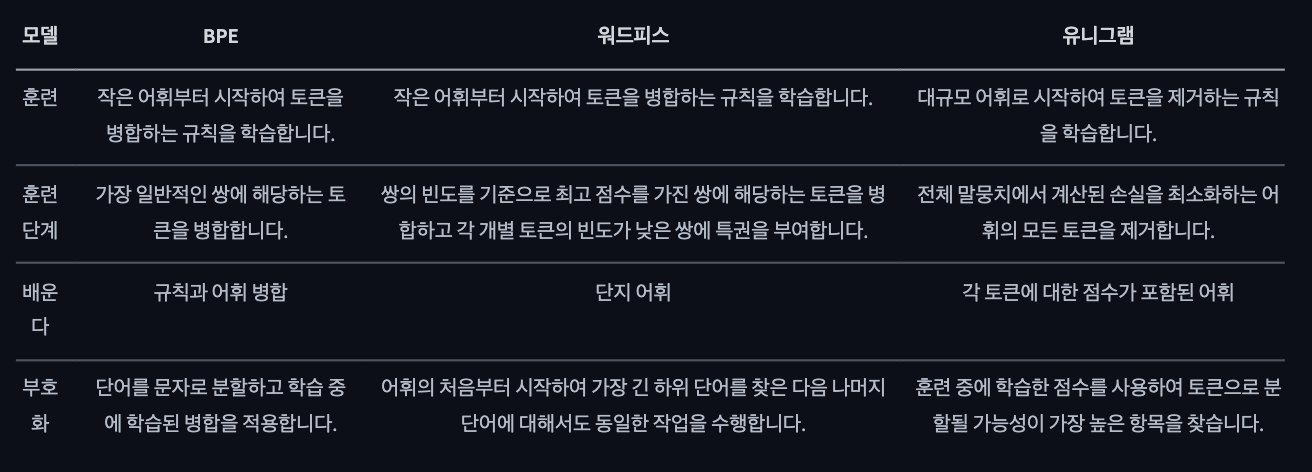

### BPE

<알고리즘>
1. 단어를 구성하는 모든 기호들 나열.
2. 가장 빈번한 토큰 쌍(연속 토큰)을 병합.
3. 원하는 어휘 크기에 도달할 때까지 2번을 반복.

In [8]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

사전 토큰화하기

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

corpus에 있는 각 단어의 빈도를 계산

In [10]:
from collections import defaultdict

word_freqs = defaultdict(int)

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


corpus에 사용된 모든 문자(알파벳)로 구성된 기본 어휘를 계산

In [11]:
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print(alphabet)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


어휘의 시작 부분에 특수 토큰을 추가. GPT-2의 경우에는 유일한 특수 토큰 <|endoftext|> 이 있음.

In [12]:
vocab = ["<|endoftext|>"] + alphabet.copy()

In [14]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


단어를 개별 characters로 쪼갠다.

In [15]:
splits = {word: [c for c in word] for word in word_freqs.keys()}

In [16]:
print(splits)

{'This': ['T', 'h', 'i', 's'], 'Ġis': ['Ġ', 'i', 's'], 'Ġthe': ['Ġ', 't', 'h', 'e'], 'ĠHugging': ['Ġ', 'H', 'u', 'g', 'g', 'i', 'n', 'g'], 'ĠFace': ['Ġ', 'F', 'a', 'c', 'e'], 'ĠCourse': ['Ġ', 'C', 'o', 'u', 'r', 's', 'e'], '.': ['.'], 'Ġchapter': ['Ġ', 'c', 'h', 'a', 'p', 't', 'e', 'r'], 'Ġabout': ['Ġ', 'a', 'b', 'o', 'u', 't'], 'Ġtokenization': ['Ġ', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n'], 'Ġsection': ['Ġ', 's', 'e', 'c', 't', 'i', 'o', 'n'], 'Ġshows': ['Ġ', 's', 'h', 'o', 'w', 's'], 'Ġseveral': ['Ġ', 's', 'e', 'v', 'e', 'r', 'a', 'l'], 'Ġtokenizer': ['Ġ', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'e', 'r'], 'Ġalgorithms': ['Ġ', 'a', 'l', 'g', 'o', 'r', 'i', 't', 'h', 'm', 's'], 'Hopefully': ['H', 'o', 'p', 'e', 'f', 'u', 'l', 'l', 'y'], ',': [','], 'Ġyou': ['Ġ', 'y', 'o', 'u'], 'Ġwill': ['Ġ', 'w', 'i', 'l', 'l'], 'Ġbe': ['Ġ', 'b', 'e'], 'Ġable': ['Ġ', 'a', 'b', 'l', 'e'], 'Ġto': ['Ġ', 't', 'o'], 'Ġunderstand': ['Ġ', 'u', 'n', 'd', 'e', 'r', 's', 't', 'a', 'n', 'd'], 'Ġh

각 pairs의 빈도를 계산하는 함수 작성

In [17]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

In [18]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('T', 'h'): 3
('h', 'i'): 3
('i', 's'): 5
('Ġ', 'i'): 2
('Ġ', 't'): 7
('t', 'h'): 3


('Ġ', 't'): 7 로 젤 많음.

In [19]:
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

('Ġ', 't') 7


In [20]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

병합하는 함수 작성

In [21]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [22]:
splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


이제 목표하는 vocab size가 50이라고 가정하고, loop문을 작성한다.

In [23]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

아라와 같이 19개의 merge rules가 생성되었다.

In [24]:
print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab', ('Ġtoken', 'i'): 'Ġtokeni'}


이제 vocabulary가 초기알파벳과 병합 결과로 생긴 단어들로 총 50개 구성되었다.

In [25]:
print(vocab)

['<|endoftext|>', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ', 'Ġt', 'is', 'er', 'Ġa', 'Ġto', 'en', 'Th', 'This', 'ou', 'se', 'Ġtok', 'Ġtoken', 'nd', 'Ġis', 'Ġth', 'Ġthe', 'in', 'Ġab', 'Ġtokeni']


위와 같이 학습을 통해 룰을 생성했다.

이제 새로운 텍스트를 토큰화하려면, pre-tokenization하고 분할 한 후 모든 병합 규칙을 적용하면 된다.

In [34]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

아래와 같이 BPE의 병합 규칙이 적용되어 토큰화된 것을 확인할 수 있다.

In [30]:
tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

In [35]:
tokenize("Is this yours?")

['I', 's', 'Ġth', 'is', 'Ġ', 'y', 'ou', 'r', 's', '?']

### WorldPiece

* WordPiece는 Google이 BERT를 사전 훈련하기 위해 개발한 토큰화 알고리즘.
* 이후 Transformer 모델에서 사용됨.

In [36]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

단어로 사전 토큰화

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

각 word의 빈도 계산

In [38]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'This': 3,
             'is': 2,
             'the': 1,
             'Hugging': 1,
             'Face': 1,
             'Course': 1,
             '.': 4,
             'chapter': 1,
             'about': 1,
             'tokenization': 1,
             'section': 1,
             'shows': 1,
             'several': 1,
             'tokenizer': 1,
             'algorithms': 1,
             'Hopefully': 1,
             ',': 1,
             'you': 1,
             'will': 1,
             'be': 1,
             'able': 1,
             'to': 1,
             'understand': 1,
             'how': 1,
             'they': 1,
             'are': 1,
             'trained': 1,
             'and': 1,
             'generate': 1,
             'tokens': 1})

In [39]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
alphabet

print(alphabet)

['##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y']


특수 토큰 추가

In [40]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()

"##" 접두사가 붙지 않은 모든 문자를 사용하여 각 단어를 분할

In [41]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}

In [44]:
print(splits)

{'This': ['T', '##h', '##i', '##s'], 'is': ['i', '##s'], 'the': ['t', '##h', '##e'], 'Hugging': ['H', '##u', '##g', '##g', '##i', '##n', '##g'], 'Face': ['F', '##a', '##c', '##e'], 'Course': ['C', '##o', '##u', '##r', '##s', '##e'], '.': ['.'], 'chapter': ['c', '##h', '##a', '##p', '##t', '##e', '##r'], 'about': ['a', '##b', '##o', '##u', '##t'], 'tokenization': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##a', '##t', '##i', '##o', '##n'], 'section': ['s', '##e', '##c', '##t', '##i', '##o', '##n'], 'shows': ['s', '##h', '##o', '##w', '##s'], 'several': ['s', '##e', '##v', '##e', '##r', '##a', '##l'], 'tokenizer': ['t', '##o', '##k', '##e', '##n', '##i', '##z', '##e', '##r'], 'algorithms': ['a', '##l', '##g', '##o', '##r', '##i', '##t', '##h', '##m', '##s'], 'Hopefully': ['H', '##o', '##p', '##e', '##f', '##u', '##l', '##l', '##y'], ',': [','], 'you': ['y', '##o', '##u'], 'will': ['w', '##i', '##l', '##l'], 'be': ['b', '##e'], 'able': ['a', '##b', '##l', '##e'], 'to': ['t', '##o'],

각 쌍의 점수를 계산하는 함수를 작성

In [42]:
def compute_pair_scores(splits):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

일부 출력

In [45]:
pair_scores = compute_pair_scores(splits)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('T', '##h'): 0.125
('##h', '##i'): 0.03409090909090909
('##i', '##s'): 0.02727272727272727
('i', '##s'): 0.1
('t', '##h'): 0.03571428571428571
('##h', '##e'): 0.011904761904761904


가장 좋은 점수를 가진 쌍을 찾기

In [46]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('a', '##b') 0.2


어휘에 ('a', '##b') -> 'ab'추가

In [47]:
vocab.append("ab")

병합을 적용

In [48]:
def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [49]:
splits = merge_pair("a", "##b", splits)
splits["about"]

['ab', '##o', '##u', '##t']

어휘 크기를 70으로 목표로 원하는 병합을 모두 train할 때까지 반복

In [50]:
vocab_size = 70
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

BPE에 비해 이 토크나이저는 단어의 일부를 토큰으로 조금 더 빠르게 학습

In [51]:
print(vocab)

['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##a', '##b', '##c', '##d', '##e', '##f', '##g', '##h', '##i', '##k', '##l', '##m', '##n', '##o', '##p', '##r', '##s', '##t', '##u', '##v', '##w', '##y', '##z', ',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'g', 'h', 'i', 's', 't', 'u', 'w', 'y', 'ab', '##fu', 'Fa', 'Fac', '##ct', '##ful', '##full', '##fully', 'Th', 'ch', '##hm', 'cha', 'chap', 'chapt', '##thm', 'Hu', 'Hug', 'Hugg', 'sh', 'th', 'is', '##thms', '##za', '##zat', '##ut']


새 텍스트를 토큰화를 위한 함수 작성
1. 사전 토큰화하고 분할
2. 각 단어에 토큰화 알고리즘 적용

In [52]:
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [53]:
print(encode_word("Hugging"))
print(encode_word("HOgging"))

['Hugg', '##i', '##n', '##g']
['[UNK]']


텍스트를 토큰화하는 함수

In [54]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    encoded_words = [encode_word(word) for word in pre_tokenized_text]
    return sum(encoded_words, [])

In [55]:
tokenize("This is the Hugging Face course!")

['Th',
 '##i',
 '##s',
 'is',
 'th',
 '##e',
 'Hugg',
 '##i',
 '##n',
 '##g',
 'Fac',
 '##e',
 'c',
 '##o',
 '##u',
 '##r',
 '##s',
 '##e',
 '[UNK]']

### Unigram

AlBERT, T5, mBART, Big Bird 및 XLNet과 같은 모델에서 사용되는 토큰화 알고리즘인 SentencePiece에서 자주 사용

In [56]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

In [57]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

 각 단어의 발생 횟수를 계산

In [58]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

defaultdict(int,
            {'▁This': 3,
             '▁is': 2,
             '▁the': 1,
             '▁Hugging': 1,
             '▁Face': 1,
             '▁Course.': 1,
             '▁chapter': 1,
             '▁about': 1,
             '▁tokenization.': 1,
             '▁section': 1,
             '▁shows': 1,
             '▁several': 1,
             '▁tokenizer': 1,
             '▁algorithms.': 1,
             '▁Hopefully,': 1,
             '▁you': 1,
             '▁will': 1,
             '▁be': 1,
             '▁able': 1,
             '▁to': 1,
             '▁understand': 1,
             '▁how': 1,
             '▁they': 1,
             '▁are': 1,
             '▁trained': 1,
             '▁and': 1,
             '▁generate': 1,
             '▁tokens.': 1})

 더 큰 하위 문자열의 경우 가장 일반적인 문자만 유지하므로 빈도별로 정렬

In [59]:
char_freqs = defaultdict(int)
subwords_freqs = defaultdict(int)
for word, freq in word_freqs.items():
    for i in range(len(word)):
        char_freqs[word[i]] += freq
        # Loop through the subwords of length at least 2
        for j in range(i + 2, len(word) + 1):
            subwords_freqs[word[i:j]] += freq

# Sort subwords by frequency
sorted_subwords = sorted(subwords_freqs.items(), key=lambda x: x[1], reverse=True)
sorted_subwords[:10]

[('▁t', 7),
 ('is', 5),
 ('er', 5),
 ('▁a', 5),
 ('▁to', 4),
 ('to', 4),
 ('en', 4),
 ('▁T', 3),
 ('▁Th', 3),
 ('▁Thi', 3)]

크기 300의 초기 어휘에 도달하기 위해 가장 좋은 하위 단어로 문자를 그룹화

In [60]:
token_freqs = list(char_freqs.items()) + sorted_subwords[: 300 - len(char_freqs)]
token_freqs = {token: freq for token, freq in token_freqs}

* 모든 빈도의 합을 계산하여 빈도를 확률로 변환
* 모델의 경우 확률의 로그를 저장. 왜냐하면 작은 숫자를 곱하는 것보다 로그를 추가하는 것이 수치적으로 더 안정적

In [62]:
from math import log

total_sum = sum([freq for token, freq in token_freqs.items()])
model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

Viterbi 알고리즘을 사용하여 단어를 토큰화
* 해당 알고리즘은 단어의 각 하위 문자열에 대한 최상의 분할을 계산하고 이를 best_segmentations 변수라는 이름에 저장합니다
* 우리는 두 개의 키, 즉 최고의 분할에서 마지막 토큰의 시작 인덱스와 최고의 분할 점수를 사용하여 단어의 위치당 하나의 사전(0부터 전체 길이까지)을 저장

In [63]:
def encode_word(word, model):
    best_segmentations = [{"start": 0, "score": 1}] + [
        {"start": None, "score": None} for _ in range(len(word))
    ]
    for start_idx in range(len(word)):
        # This should be properly filled by the previous steps of the loop
        best_score_at_start = best_segmentations[start_idx]["score"]
        for end_idx in range(start_idx + 1, len(word) + 1):
            token = word[start_idx:end_idx]
            if token in model and best_score_at_start is not None:
                score = model[token] + best_score_at_start
                # If we have found a better segmentation ending at end_idx, we update
                if (
                    best_segmentations[end_idx]["score"] is None
                    or best_segmentations[end_idx]["score"] > score
                ):
                    best_segmentations[end_idx] = {"start": start_idx, "score": score}

    segmentation = best_segmentations[-1]
    if segmentation["score"] is None:
        # We did not find a tokenization of the word -> unknown
        return ["<unk>"], None

    score = segmentation["score"]
    start = segmentation["start"]
    end = len(word)
    tokens = []
    while start != 0:
        tokens.insert(0, word[start:end])
        next_start = best_segmentations[start]["start"]
        end = start
        start = next_start
    tokens.insert(0, word[start:end])
    return tokens, score

일부 단어에 대해 초기 모델을 시험해 볼 수 있습니다.

In [64]:
print(encode_word("Hopefully", model))
print(encode_word("This", model))

(['H', 'o', 'p', 'e', 'f', 'u', 'll', 'y'], 41.5157494601402)
(['This'], 6.288267030694535)


이제 코퍼스에서 모델의 손실을 쉽게 계산할 수 있습니다

In [65]:
def compute_loss(model):
    loss = 0
    for word, freq in word_freqs.items():
        _, word_loss = encode_word(word, model)
        loss += freq * word_loss
    return loss

In [66]:
compute_loss(model)

413.10377642940875

 각 토큰을 삭제하여 얻은 모델의 손실을 계산

In [67]:
import copy


def compute_scores(model):
    scores = {}
    model_loss = compute_loss(model)
    for token, score in model.items():
        # We always keep tokens of length 1
        if len(token) == 1:
            continue
        model_without_token = copy.deepcopy(model)
        _ = model_without_token.pop(token)
        scores[token] = compute_loss(model_without_token) - model_loss
    return scores

 "his"는 자체적으로 토큰화된 단어 내에서만 사용되므로 "This"손실이 전혀 없을 것

In [68]:
scores = compute_scores(model)
print(scores["ll"])
print(scores["his"])

6.376412403623874
0.0


모델에서 사용하는 특수 토큰을 어휘에 추가한 다음 원하는 크기에 도달할 만큼 어휘에서 충분한 토큰을 잘라낼 때까지 반복하는 것 (%)

In [69]:
percent_to_remove = 0.1
while len(model) > 100:
    scores = compute_scores(model)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1])
    # Remove percent_to_remove tokens with the lowest scores.
    for i in range(int(len(model) * percent_to_remove)):
        _ = token_freqs.pop(sorted_scores[i][0])

    total_sum = sum([freq for token, freq in token_freqs.items()])
    model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

일부 텍스트를 토큰화하려면 사전 토큰화를 적용한 다음 함수를 사용하면 됨

In [70]:
def tokenize(text, model):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in words_with_offsets]
    encoded_words = [encode_word(word, model)[0] for word in pre_tokenized_text]
    return sum(encoded_words, [])


tokenize("This is the Hugging Face course.", model)

['▁This',
 '▁is',
 '▁the',
 '▁Hugging',
 '▁Face',
 '▁',
 'c',
 'ou',
 'r',
 's',
 'e',
 '.']

### Building a tokenizer, block by block

#### Acquiring a corpus

get_training_corpus(): 토크나이저를 훈련하는 데 사용할 1,000개의 텍스트 배치를 생성하는 생성기

In [71]:
from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")


def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["text"]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [72]:
with open("wikitext-2.txt", "w", encoding="utf-8") as f:
    for i in range(len(dataset)):
        f.write(dataset[i]["text"] + "\n")

#### Building a WordPiece tokenizer from scratch

* Tokenizers 라이브러리를 사용하여 토크나이저를 구축하려면 먼저 모델을 사용하여 Tokenizer 객체를 인스턴스화한 다음 해당 Normalizer, pre_tokenizer, post_processor 및 decoder 속성을 원하는 값으로 설정합니다.

In [73]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

**[Normalization]**

In [74]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

만약 정규화를 직접 구성한다면?

In [76]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)
# NFD 사용이유: StripAccents 노멀라이저가 악센트 문자를 제대로 인식하도록.

In [77]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))

hello how are u?


**[pre-tokenization]**

In [78]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

In [79]:
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

In [81]:
# 공백 사전 토크나이저는 공백과 문자, 숫자 또는 밑줄 문자가 아닌 모든 문자로 분할되므로 기술적으로 공백과 구두점으로 분할
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

In [82]:
# 공백으로만 분할하려면 대신 WhitespaceSplit 사전 토크나이저를 사용해야 합니다.
pre_tokenizer = pre_tokenizers.WhitespaceSplit()
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[("Let's", (0, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre-tokenizer.', (14, 28))]

정규화 때처럼 Sequence로 직접 구성해도 된다.

In [83]:
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

**[Model]**

이때 모든 특수 토큰을 전달해야 한다!

In [84]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)

vocab_size 및 special_tokens 를 지정하는 것 외에도 min_frequency (토큰이 어휘에 포함되어야 하는 것으로 나타나는 횟수)를 설정하거나 continue_subword_prefix(##과 다른 것을 사용하려는 경우)를 변경할 수 있습니다.

In [85]:
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

텍스트 파일을 사용하여 토크나이저를 훈련할 수도 있습니다.

In [86]:
tokenizer.model = models.WordPiece(unk_token="[UNK]")
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

두 경우 모두 encode() 메서드를 호출하여 텍스트에 대한 토크나이저를 테스트할 수 있습니다.

In [87]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.']


In [88]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

2 3


**[Postprocessor]**

첫 번째(또는 단일) 문장은 $A로 표시되고, 두 번째 문장(쌍으로 인코딩된 경우)은 $B로 표시됩니다.

In [89]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[("[CLS]", cls_token_id), ("[SEP]", sep_token_id)],
)

In [90]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '.', '[SEP]']


In [91]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

['[CLS]', 'let', "'", 's', 'test', 'this', 'tok', '##eni', '##zer', '...', '[SEP]', 'on', 'a', 'pair', 'of', 'sentences', '.', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


In [92]:
tokenizer.decoder = decoders.WordPiece(prefix="##")

In [93]:
tokenizer.decode(encoding.ids)

"let ' s test this tokenizer... on a pair of sentences."

tokenizer in a single JSON file로 저장

In [94]:
tokenizer.save("tokenizer.json")

로드 가능

In [95]:
new_tokenizer = Tokenizer.from_file("tokenizer.json")

Transformers에서 이 토크나이저를 사용하려면 PreTrainedTokenizerFast에 래핑해야 합니다

In [96]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    # tokenizer_file="tokenizer.json", # You can load from the tokenizer file, alternatively
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

In [97]:
from transformers import BertTokenizerFast

wrapped_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

#### Building a BPE tokenizer from scratch

GPT2는 normalizer를 사용하지 않기 때문에 스킵하고 바로 pre-tokenization부터 간다.

**[Pre-tokenization]**

In [98]:
tokenizer = Tokenizer(models.BPE())

In [99]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

In [100]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization!")

[('Let', (0, 3)),
 ("'s", (3, 5)),
 ('Ġtest', (5, 10)),
 ('Ġpre', (10, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28))]

**[Model]**

In [101]:
trainer = trainers.BpeTrainer(vocab_size=25000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

In [102]:
tokenizer.model = models.BPE()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [103]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['L', 'et', "'", 's', 'Ġtest', 'Ġthis', 'Ġto', 'ken', 'izer', '.']


**[Postprocessor]**

byte-level post-processing for the GPT-2 tokenizer

In [106]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
# Trim_offsets = False 옵션은 'Ġ'로 시작하는 토큰의 오프셋을 그대로 두어야 함
# 따라서 오프셋의 시작 부분은 단어의 첫 번째 문자가 아닌 단어 앞의 공백을 가리키게 됩니다

In [107]:
sentence = "Let's test this tokenizer."
encoding = tokenizer.encode(sentence)
start, end = encoding.offsets[4] # 'Ġtest'가 인덱스 4에 있는 텍스트의 결과를 살펴보겠습니다
sentence[start:end]

' test'

In [108]:
tokenizer.decoder = decoders.ByteLevel()

In [109]:
tokenizer.decode(encoding.ids)

"Let's test this tokenizer."

트랜스포머에서 사용할려면 아래와 같이 작성

In [110]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<|endoftext|>",
    eos_token="<|endoftext|>",
)

또는 아래와 같이 작성

In [111]:
from transformers import GPT2TokenizerFast

wrapped_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)

#### Building a Unigram tokenizer from scratch

XLNet tokenizer

In [112]:
tokenizer = Tokenizer(models.Unigram())

**[Normalization]**

In [113]:
from tokenizers import Regex

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

**[Pre-tokenization]**

In [114]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

In [115]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test the pre-tokenizer!")

[("▁Let's", (0, 5)),
 ('▁test', (5, 10)),
 ('▁the', (10, 14)),
 ('▁pre-tokenizer!', (14, 29))]

**[Model]**

In [116]:
special_tokens = ["<cls>", "<sep>", "<unk>", "<pad>", "<mask>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=25000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

텍스트 파일을 학습할 수도 있음.

In [117]:
tokenizer.model = models.Unigram()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In [118]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.']


* XLNet의 특징은 다른 토큰과 구별하기 위해 유형 ID가 2인 cls 토큰을 문장 끝에 넣는 것
* 결과적으로 왼쪽에 채워지게 됨.
* BERT와 같이 모든 특수 토큰과 토큰 유형 ID를 다루기 위해 템플릿을 사용할 수 있지만, 먼저 cls 및 sep 토큰의 ID를 얻어야한다.

**[PostProcessor]**

In [119]:
cls_token_id = tokenizer.token_to_id("<cls>")
sep_token_id = tokenizer.token_to_id("<sep>")
print(cls_token_id, sep_token_id)

0 1


In [120]:
tokenizer.post_processor = processors.TemplateProcessing(
    single="$A:0 <sep>:0 <cls>:2", # ID가 2인 <CLS> 토큰
    pair="$A:0 <sep>:0 $B:1 <sep>:1 <cls>:2",
    special_tokens=[("<sep>", sep_token_id), ("<cls>", cls_token_id)],
)

In [121]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)
print(encoding.type_ids)

['▁Let', "'", 's', '▁test', '▁this', '▁to', 'ken', 'izer', '.', '.', '.', '<sep>', '▁', 'on', '▁', 'a', '▁pair', '▁of', '▁sentence', 's', '!', '<sep>', '<cls>']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


In [122]:
tokenizer.decoder = decoders.Metaspace()

트랜스포머에서 사용할려면

In [123]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
    cls_token="<cls>",
    sep_token="<sep>",
    mask_token="<mask>",
    padding_side="left",
)

또는 아래와 같이 작성.

In [124]:
from transformers import XLNetTokenizerFast

wrapped_tokenizer = XLNetTokenizerFast(tokenizer_object=tokenizer)